In [127]:
import pandas as pd
import numpy as np
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from IPython.display import display
from geopy.distance import geodesic
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
ratings = pd.read_csv('dataset/FilteredData/ratings_difference.csv')

In [129]:
users = pd.read_csv('dataset/FilteredData/users.csv')

In [141]:
#Rewrite helper function to get the difference with the global mean and diffrence with global percentage

def location_style_stats(ratings, users, year,loc_style_threshold ):
    year_filter = ratings['year'] == year
    ratings = ratings.loc[year_filter]
    
    ratings = pd.merge(ratings, users[['user_id', 'nbr_ratings', 'location']], on='user_id', how='inner')

    ratings_groupedby_loc_style = ratings.groupby(['location', 'style'])
    ratings_style = ratings.groupby("style")
    total_nb = len(ratings)
    
    location_style = ratings_groupedby_loc_style.size().reset_index(name='number')
    ratings_groupedby_loc = ratings.groupby('location')
    ratings_loc = ratings_groupedby_loc.size().reset_index(name='total_loc_number')

    #Get the counts for each style globally
    
    style_counts = ratings['style'].value_counts()
    global_style = pd.DataFrame({'style': style_counts.index, 'total_number': style_counts.values})
   
    global_style['percentage'] = 100* (global_style['total_number'] / total_nb)
    
    ratings_loc['location_mean'] = ratings_groupedby_loc['rating'].mean().reset_index(name='location_mean')[
        'location_mean']
    ratings_loc['location_std'] = ratings_groupedby_loc['rating'].std().reset_index(name='location_std')[
        'location_std']
    ratings_loc['location_std'] = ratings_loc['location_std'].fillna(1)
    
    ratings_global = pd.DataFrame()
    ratings_global['global_mean'] = ratings_style['rating'].mean()
    ratings_global = ratings_global.reset_index()
   
   #For now, comment that to save computing time
    
    #ratings_loc['normalized_rating'] = ratings.apply(lambda row: abs(row['rating'] - ratings_global.loc[(ratings_global['style'] == row['style'])]['global_mean'].values[0]), axis = 1)
    
    location_style = pd.merge(location_style, ratings_loc, on='location', how='inner')

    location_style['popularity_percentage'] = 100 * (location_style['number'] / location_style['total_loc_number'])

   

    #> 0 if more popular than global
    location_style['difference_percentage'] = location_style.apply(lambda row: row['popularity_percentage'] - global_style.loc[(global_style['style'] == row['style'])]['percentage'].values[0], axis = 1)
    
    location_style['mean_rating'] = ratings_groupedby_loc_style['rating'].mean().reset_index(name='mean_rating')['mean_rating']
    location_style = location_style[
        ['location', 'style', 'number', 'total_loc_number', 'popularity_percentage', 'mean_rating', 'location_mean',
         'location_std', 'difference_percentage']]
    location_style['z_score'] = (location_style['mean_rating'] - location_style['location_mean']) / location_style[
        'location_std']
    location_style = location_style[location_style['number'] >= loc_style_threshold]

    return location_style

In [188]:
#Trend = most different from the global mean

years = np.arange(2006, 2018)
print(years)
popularity_by_difference = pd.DataFrame()
for year in years:
    print(year)
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_most_popular = location_style_groupedby_loc['difference_percentage'].idxmax()
    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    popularity_by_difference = pd.concat([popularity_by_difference, most_popular_styles_by_location], axis = 1)



[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [189]:
#Compare it with when we don't do with the difference
#Took absolute value for those results : maybe not good

popularity_by_difference.to_csv('dataset/FilteredData/style_popularities_by_year.csv', index = True)

In [190]:
#When set the most popular, also get the difference with the global mean

years = np.arange(2006, 2018)
print(years)
style_popularities_by_year = pd.DataFrame()
for year in years:
    print(year)
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    location_style_groupedby_loc = location_style.groupby('location')
    #Get most popular style with number of ratings
    idx_most_popular = location_style_groupedby_loc['number'].idxmax()

    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style', 'difference_percentage']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'difference_percentage': 'diff-'+str(year)})
    style_popularities_by_year = pd.concat([style_popularities_by_year, most_popular_styles_by_location], axis = 1)



[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


<Axes: >

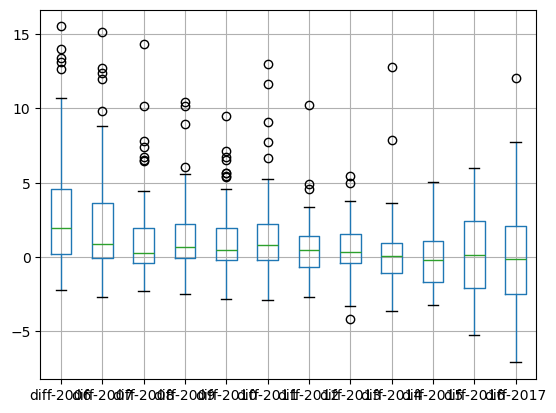

In [149]:
#Plot boxplot of the difference with global mean for each year, with preferred style (no threshold)
diff_columns = [col for col in style_popularities_by_year.columns if col.startswith('diff')]
style_popularities_by_year[diff_columns].boxplot()


In [ ]:
#Observe that without threshold, the percentage of ratings for the preferred style gets closer to the global mean

In [191]:
#Let's look at the difference between the obtained preferred styles with the two techniques

#select columns of style_popularities_by_year that don't start with diff
no_diff_columns = [col for col in style_popularities_by_year.columns if col.startswith('2')]

#Table with True if the value is the same between style_popularities_by_year and popularity_by_difference for columns with same name
#False if different
popularity_by_difference == style_popularities_by_year[no_diff_columns]

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,True,True,True,True,False,False,False,False,False,False,False,False
Canada,True,True,False,False,False,False,False,False,False,False,False,False
England,True,True,False,True,True,True,True,False,False,False,False,False
Germany,False,False,True,True,False,False,False,False,True,False,False,False
Italy,False,True,True,True,True,True,False,False,True,False,False,False
Netherlands,True,True,False,True,False,False,False,False,False,False,True,True
Northern Ireland,True,True,False,False,False,True,False,False,False,False,True,True
Scotland,True,False,True,True,False,True,False,False,False,False,False,False
Sweden,True,True,True,False,True,True,False,False,False,False,False,False


In [156]:
no_diff_columns = [col for col in style_popularities_by_year.columns if col.startswith('2')]

In [213]:
#Set the treshold of difference to 3% with the global mean, and get preferred styles

years = np.arange(2006, 2018)
print(years)
style_popularities_by_year_thr3 = pd.DataFrame()
for year in years:
    print(year)
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    location_style = location_style.loc[location_style['difference_percentage'] > 3]

    location_style_groupedby_loc = location_style.groupby('location')
    #Get most popular style with number of ratings
    idx_most_popular = location_style_groupedby_loc['number'].idxmax()

    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style', 'difference_percentage']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'difference_percentage': 'diff-'+str(year)})
    style_popularities_by_year_thr3 = pd.concat([style_popularities_by_year_thr3, most_popular_styles_by_location], axis = 1)



[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [214]:
style_popularities_by_year_thr3
#with thr =3, lots of NaN

,2006,diff-2006,2007,diff-2007,2008,diff-2008,2009,diff-2009,2010,diff-2010,...,2013,diff-2013,2014,diff-2014,2015,diff-2015,2016,diff-2016,2017,diff-2017
location,,,,,,,,,,,,,,,,,,,,,
Australia,Pale Lager,10.672702,Pale Lager,11.951963,Pale Lager,6.546114,Pale Lager,4.792781,NaN,NaN,...,NaN,NaN,Pale Lager,4.365614,American Pale Ale,4.088491,American Pale Ale,4.041703,Pale Lager,9.499283
Canada,Pale Lager,4.547878,Pale Lager,3.332752,NaN,NaN,Pale Lager,3.626162,Pale Lager,3.463054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
England,Bitter,13.373502,Bitter,15.109288,Pale Lager,7.377397,Bitter,8.958273,Bitter,7.133874,...,Bitter,9.477038,Golden Ale/Blond Ale,6.352787,Golden Ale/Blond Ale,6.253084,Golden Ale/Blond Ale,5.744993,Golden Ale/Blond Ale,4.079614
Germany,German Hefeweizen,3.418947,Pilsener,3.746261,NaN,NaN,German Hefeweizen,5.611654,Pilsener,5.139278,...,Pilsener,5.464672,Pilsener,7.902569,Pilsener,5.158169,Pale Lager,5.560832,Pilsener,5.467130
Italy,Pale Lager,6.934384,Belgian Ale,9.860020,Dortmunder/Helles,10.148676,Pilsener,10.462122,Pilsener,9.501598,...,Pale Lager,3.019735,Pale Lager,12.816756,Pale Lager,9.486927,Pale Lager,7.622990,Pale Lager,6.668003
Netherlands,Belgian Strong Ale,10.308380,Belgian Ale,8.820433,Belgian Strong Ale,4.314407,Belgian Strong Ale,6.036241,Imperial Stout,4.582639,...,Belgian Strong Ale,5.424997,Pale Lager,4.638841,Belgian Strong Ale,3.694081,Imperial Stout,3.252433,NaN,NaN
Northern Ireland,Golden Ale/Blond Ale,6.408304,Bitter,7.792176,Golden Ale/Blond Ale,3.354275,India Pale Ale (IPA),3.347018,Bitter,6.628823,...,American Pale Ale,6.415993,Golden Ale/Blond Ale,9.028995,Golden Ale/Blond Ale,3.133173,India Pale Ale (IPA),5.990186,India Pale Ale (IPA),12.065841
Scotland,Scottish Ale,15.512824,Golden Ale/Blond Ale,7.115007,Golden Ale/Blond Ale,14.347183,Golden Ale/Blond Ale,10.155342,Pale Lager,6.711772,...,Pale Lager,6.215167,Golden Ale/Blond Ale,6.796544,Pale Lager,5.940098,Pale Lager,3.208387,Pale Lager,3.475954
Sweden,Pale Lager,13.090125,Pale Lager,6.506691,Pale Lager,7.808088,Pale Lager,3.549033,Pale Lager,5.401276,...,NaN,NaN,Pale Lager,3.030430,NaN,NaN,NaN,NaN,India Pale Ale (IPA),3.037703


In [195]:
#Do the same with a threshold of 1%

years = np.arange(2006, 2018)
print(years)
style_popularities_by_year_thr1 = pd.DataFrame()
for year in years:
    print(year)
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    location_style = location_style.loc[location_style['difference_percentage'] > 1]

    location_style_groupedby_loc = location_style.groupby('location')
    #Get most popular style with number of ratings
    idx_most_popular = location_style_groupedby_loc['number'].idxmax()

    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style', 'difference_percentage']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'difference_percentage': 'diff-'+str(year)})
    style_popularities_by_year_thr1 = pd.concat([style_popularities_by_year_thr1, most_popular_styles_by_location], axis = 1)



[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [196]:
style_popularities_by_year_thr1

,2006,diff-2006,2007,diff-2007,2008,diff-2008,2009,diff-2009,2010,diff-2010,...,2013,diff-2013,2014,diff-2014,2015,diff-2015,2016,diff-2016,2017,diff-2017
location,,,,,,,,,,,,,,,,,,,,,
Australia,Pale Lager,10.672702,Pale Lager,11.951963,Pale Lager,6.546114,Pale Lager,4.792781,Pale Lager,2.103872,...,Pale Lager,2.459121,American Pale Ale,2.836173,American Pale Ale,4.088491,American Pale Ale,4.041703,Pale Lager,9.499283
Canada,Pale Lager,4.547878,Pale Lager,3.332752,Pale Lager,1.904709,Pale Lager,3.626162,Pale Lager,3.463054,...,Pale Lager,2.802306,Pale Lager,2.375071,Pale Lager,1.885762,Saison,2.264704,Saison,2.480750
England,Bitter,13.373502,Bitter,15.109288,Pale Lager,7.377397,Bitter,8.958273,Bitter,7.133874,...,Bitter,9.477038,Golden Ale/Blond Ale,6.352787,Golden Ale/Blond Ale,6.253084,Golden Ale/Blond Ale,5.744993,American Pale Ale,2.350263
Germany,German Hefeweizen,3.418947,Pale Lager,1.529117,Pale Lager,2.609223,German Hefeweizen,5.611654,Pilsener,5.139278,...,Pilsener,5.464672,Pilsener,7.902569,Pilsener,5.158169,Pale Lager,5.560832,Pilsener,5.467130
Italy,Pale Lager,6.934384,Belgian Ale,9.860020,Dortmunder/Helles,10.148676,Pilsener,10.462122,Pilsener,9.501598,...,Pale Lager,3.019735,Pale Lager,12.816756,Pale Lager,9.486927,Pale Lager,7.622990,Pale Lager,6.668003
Netherlands,Belgian Strong Ale,10.308380,Belgian Ale,8.820433,Belgian Strong Ale,4.314407,Belgian Strong Ale,6.036241,Imperial Stout,4.582639,...,Belgian Strong Ale,5.424997,Pale Lager,4.638841,Imperial Stout,1.577134,Imperial Stout,3.252433,Imperial Stout,2.950610
Northern Ireland,Golden Ale/Blond Ale,6.408304,Bitter,7.792176,Belgian Strong Ale,1.853848,India Pale Ale (IPA),3.347018,India Pale Ale (IPA),1.791541,...,India Pale Ale (IPA),2.308635,Golden Ale/Blond Ale,9.028995,India Pale Ale (IPA),2.522946,India Pale Ale (IPA),5.990186,India Pale Ale (IPA),12.065841
Scotland,Scottish Ale,15.512824,Golden Ale/Blond Ale,7.115007,Golden Ale/Blond Ale,14.347183,Golden Ale/Blond Ale,10.155342,Pale Lager,6.711772,...,India Pale Ale (IPA),1.592223,Golden Ale/Blond Ale,6.796544,Pale Lager,5.940098,India Pale Ale (IPA),2.624092,India Pale Ale (IPA),1.267701
Sweden,Pale Lager,13.090125,Pale Lager,6.506691,Pale Lager,7.808088,Imperial Stout,1.215763,Pale Lager,5.401276,...,Pale Lager,2.773979,Pale Lager,3.030430,Saison,2.167964,Saison,2.496016,India Pale Ale (IPA),3.037703


In [ ]:
no_diff_columns = [col for col in style_popularities_by_year_thr1.columns if col.startswith('2')]

#Table with True if the value is the same between style_popularities_by_year and popularity_by_difference for columns with same name
#False if different
style_popularities_by_year_thr1_years = style_popularities_by_year_thr1[no_diff_columns]

#count Na per year in style_popularities_by_year_thr1_years
style_popularities_by_year_thr1_years.isna().sum(axis = 0)

In [202]:
#Same with a threshold of 0.5%

years = np.arange(2006, 2018)
print(years)
style_popularities_by_year_thr0 = pd.DataFrame()
for year in years:
    print(year)
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    location_style = location_style.loc[location_style['difference_percentage'] > 0.5]

    location_style_groupedby_loc = location_style.groupby('location')
    #Get most popular style with number of ratings
    idx_most_popular = location_style_groupedby_loc['number'].idxmax()

    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style', 'difference_percentage']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'difference_percentage': 'diff-'+str(year)})
    style_popularities_by_year_thr0 = pd.concat([style_popularities_by_year_thr0, most_popular_styles_by_location], axis = 1)



[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [203]:
no_diff_columns = [col for col in style_popularities_by_year_thr0.columns if col.startswith('2')]

#Table with True if the value is the same between style_popularities_by_year and popularity_by_difference for columns with same name
#False if different
style_popularities_by_year_thr0_years = style_popularities_by_year_thr0[no_diff_columns]

#count Na per year in style_popularities_by_year_thr1_years
style_popularities_by_year_thr0_years.isna().sum(axis = 0)

2006    0
2007    0
2008    0
2009    2
2010    1
2011    0
2012    1
2013    3
2014    0
2015    0
2016    0
2017    0
dtype: int64

In [12]:
#Standard way without threshold

years = np.arange(2006, 2018)
print(years)
style_popularities_by_year = pd.DataFrame()
for year in years:
    print(year)
    location_style = location_style_stats(ratings.copy(), users.copy(), year)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_most_popular = location_style_groupedby_loc['number'].idxmax()
    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    style_popularities_by_year = pd.concat([style_popularities_by_year, most_popular_styles_by_location], axis = 1)



[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [14]:
#Can also see the evolution for each style per year

#Plot them for which the style is preferred in >5 countries
#Get number of countries for which the style is preferred, per year

preferred_style = style_popularities_by_year.apply(lambda x: x.value_counts())


popular = preferred_style.loc[preferred_style[preferred_style > 5].any(axis=1)]

<Axes: >

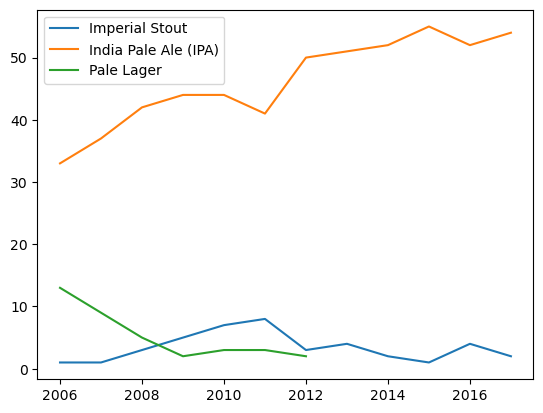

In [15]:
popular.T.plot()

In [209]:

#Plot with threshold =1
preferred_style_thr1 = style_popularities_by_year_thr1[no_diff_columns].apply(lambda x: x.value_counts())


popular1 = preferred_style_thr1[no_diff_columns].loc[preferred_style_thr1[no_diff_columns][preferred_style_thr1 > 5].any(axis=1)]

<Axes: >

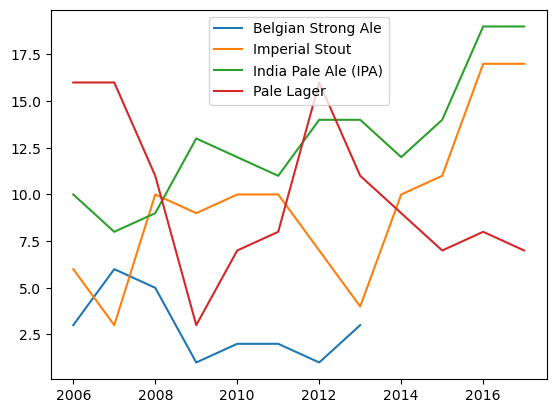

In [210]:
popular1.T.plot()

<Axes: >

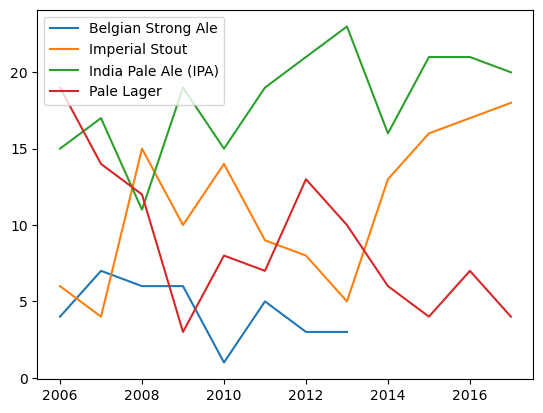

In [212]:
#Plot with threshold = 0.5
preferred_style_thr0 = style_popularities_by_year_thr0[no_diff_columns].apply(lambda x: x.value_counts())


popular0 = preferred_style_thr0[no_diff_columns].loc[preferred_style_thr0[no_diff_columns][preferred_style_thr0 > 5].any(axis=1)]
popular0.T.plot()

<Axes: >

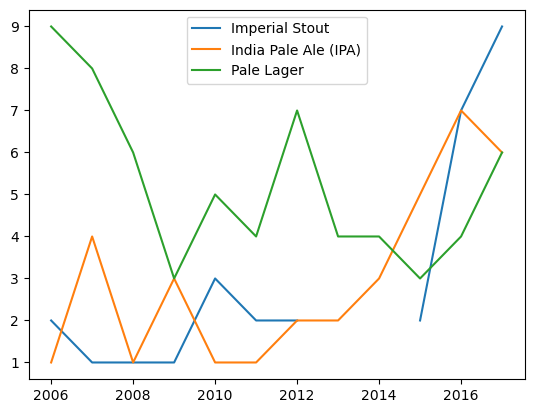

In [215]:
#Plot with threshold = 3
preferred_style_thr3 = style_popularities_by_year_thr3[no_diff_columns].apply(lambda x: x.value_counts())


popular3 = preferred_style_thr3[no_diff_columns].loc[preferred_style_thr3[no_diff_columns][preferred_style_thr3 > 5].any(axis=1)]
popular3.T.plot()

<Axes: >

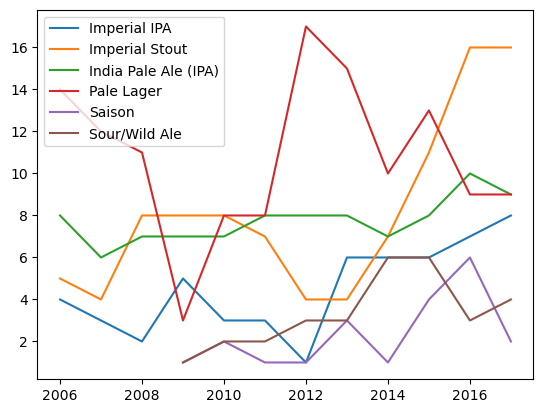

In [219]:

#Plot when popularity is only computed with the difference from global mean (preferred style = most different)


preferred_style_difference = popularity_by_difference.apply(lambda x: x.value_counts())


popular_difference = preferred_style_difference.loc[preferred_style_difference[preferred_style_difference > 5].any(axis=1)]
popular_difference.T.plot()